In [1]:
import pandas as pd
import constants
from countryinfo import CountryInfo
import geonamescache
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
plt.style.use('seaborn-bright')

gc = geonamescache.GeonamesCache()



In [2]:
populations = gc.get_countries()

from geonamescache.mappers import country as countrywrapper


def get_population_for_country(countryname):
    mapper = countrywrapper(from_key='name', to_key='iso')
    iso3 = mapper(countryname)
    if(iso3==None):
        return 1
    return populations[iso3]['population']
    

In [3]:
#from https://github.com/willhaslett/covid-19-growth/blob/master/lib/c19all.py
def df_from_csv(file_name):
    df = pd.read_csv(file_name,sep=',')
    df = df.rename(columns=constants.RENAMED_COLUMNS)
    date_cols = df.filter(regex=('^\d+/\d+/\d+$')).columns.array
    df = pd.melt(df, id_vars=['province_state', 'country', 'lat',
                                      'long'], value_vars=date_cols, var_name='date', value_name='cases')
    df.date = pd.to_datetime(df.date, format='%m/%d/%y')
    df['day'] = (df.date - pd.to_datetime(df.date.iloc[0])).astype('timedelta64[D]')
    df.day = df.day.apply(lambda day: int(round(day)))
    return df[['date', 'day', 'cases', 'province_state', 'country', 'lat', 'long']]

# General purpose filter.
def filter(df, column, value):
    return df[df[column] == value].reset_index()

# Filter on country
def for_country_per_day(df, country):
    return filter(df, 'country', country).groupby("date").sum()
eu_list = ['Austria','Belgium','Bulgaria',
'Croatia','Cypru','Czech Republic','Denmark','Estonia','Finland','France','Germany','Greece','Hungary','Ireland','Italy','Latvia','Lithuania','Luxembourg','Malta','Netherlands','Poland','Portugal','Romania','Slovakia','Slovenia','Spain','Sweden']

styles = ['bs-',
          'rs-', 
          'ys-', 
          'gs-', 
          'bo-',
          'ro-', 
          'yo-', 
          'go-',
          'b^-',
          'r^-', 
          'y^-', 
          'g^-',
          'b--',
          'r--', 
          'y--', 
          'g--']

In [4]:
confirmed = df_from_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv")
death = df_from_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv")
recovered = df_from_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv")

In [5]:
confirmed = confirmed[confirmed.country != "Cruise Ship"]

countrypop = {}
for count in confirmed.country.unique():
    countrypop[count] = get_population_for_country(count)
    
#we map instead of applying the function to reduce computational cost
confirmed["population"] = confirmed['country'].map(countrypop)
confirmed["cases_per_capita"] = confirmed["cases"]/confirmed["population"]

death = death[death.country != "Cruise Ship"]
    
#we map instead of applying the function to reduce computational cost
death["population"] = death['country'].map(countrypop)
death["cases_per_capita"] = death["cases"]/death["population"]

recovered = recovered[recovered.country != "Cruise Ship"]
    
#we map instead of applying the function to reduce computational cost
recovered["population"] = recovered['country'].map(countrypop)
recovered["cases_per_capita"] = recovered["cases"]/recovered["population"]

In [6]:
confirmed

,date,day,cases,province_state,country,lat,long,population,cases_per_capita
0,2020-01-22,0,2,NaN,Thailand,15.0000,101.0000,67089500,2.981092e-08
1,2020-01-22,0,2,NaN,Japan,36.0000,138.0000,127288000,1.571240e-08
2,2020-01-22,0,0,NaN,Singapore,1.2833,103.8333,4701069,0.000000e+00
3,2020-01-22,0,0,NaN,Nepal,28.1667,84.2500,28951852,0.000000e+00
4,2020-01-22,0,0,NaN,Malaysia,2.5000,112.5000,28274729,0.000000e+00
...,...,...,...,...,...,...,...,...,...
25755,2020-03-17,55,1,Cayman Islands,United Kingdom,19.3133,-81.2546,62348447,1.603889e-08
25756,2020-03-17,55,9,Reunion,France,-21.1351,55.2471,64768389,1.389567e-07
25757,2020-03-17,55,2,NaN,Barbados,13.1939,-59.5432,285653,7.001502e-06
25758,2020-03-17,55,2,NaN,Montenegro,42.5000,19.3000,666730,2.999715e-06


In [18]:
confirmed.groupby(["date","country"]).sum()

day  cases       lat      long  population  \
date       country                                                           
2020-01-22 Afghanistan            0      0   33.0000   65.0000    29121286   
           Albania                0      0   41.1533   20.1683     2986952   
           Algeria                0      0   28.0339    1.6596    34586184   
           Andorra                0      0   42.5063    1.5218       84000   
           Antigua and Barbuda    0      0   17.0608  -61.7964       86754   
...                             ...    ...       ...       ...         ...   
2020-03-17 United Kingdom       220   1960  160.2045  -92.4086   249393788   
           Uruguay               55     29  -32.5228  -55.7658     3477000   
           Uzbekistan            55     10   41.3775   64.5853    27865738   
           Venezuela             55     33    6.4238  -66.5897    27223228   
           Vietnam               55     66   16.0000  108.0000    89571130   

                                cases_per_capita  
date       country                                
2020-01-22 Afghanistan              0.000000e+00  
           Albania                  0.000000e+00  
           Algeria                  0.000000e+00  
           Andorra                  0.000000e+00  
           Antigua and Barbuda      0.000000e+00  
...                                          ...  
2020-03-17 United Kingdom           3.143623e-05  
           Uruguay                  8.340523e-06  
           Uzbekistan               3.588636e-07  
           Venezuela                1.212200e-06  
           Vietnam                  7.368446e-07  

[8456 rows x 6 columns]

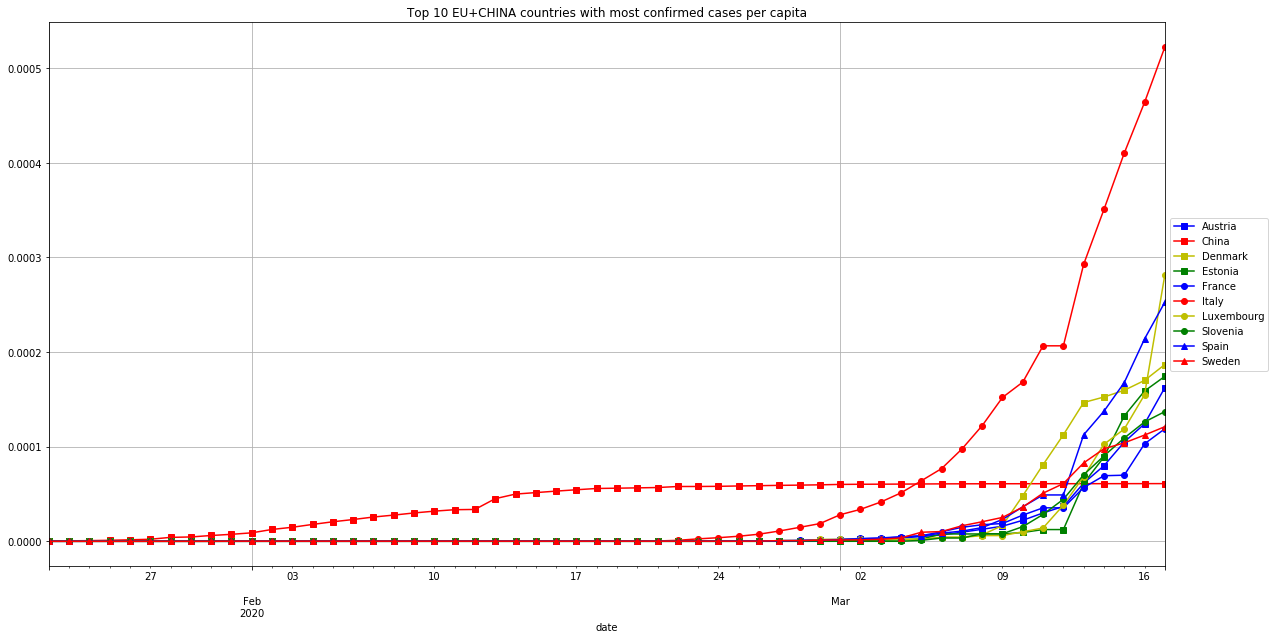

In [12]:
f, main_ax = plt.subplots()

f.set_figheight(10)
f.set_figwidth(20)

#Top 10 countries with confirmed cases per capita
top10 = confirmed[confirmed["country"].isin(eu_list+["China"])].groupby(["country"]).sum().sort_values("cases_per_capita",ascending=False).head(10).index.values

confirmed_countries = confirmed[confirmed["country"].isin(top10)].groupby(["date","country"]).sum()

confirmed_countries.unstack(level=1)["cases_per_capita"].plot(ax=main_ax,style=styles)
main_ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
main_ax.set_title("Top 10 EU+CHINA countries with most confirmed cases per capita")
# main_ax.xaxis.set_major_locator(mdates.DayLocator())
# main_ax.xaxis.set_minor_locator(mdates.DayLocator())

## Rotate date labels automatically

plt.grid()

In [10]:
confirmed[confirmed["country"].isin(eu_list)].groupby(["country"]).sum().sort_values("cases_per_capita",ascending=False).head(10).index.values

array(['Italy', 'Spain', 'Denmark', 'Luxembourg', 'Sweden', 'Estonia',
       'Austria', 'Slovenia', 'France', 'Belgium'], dtype=object)

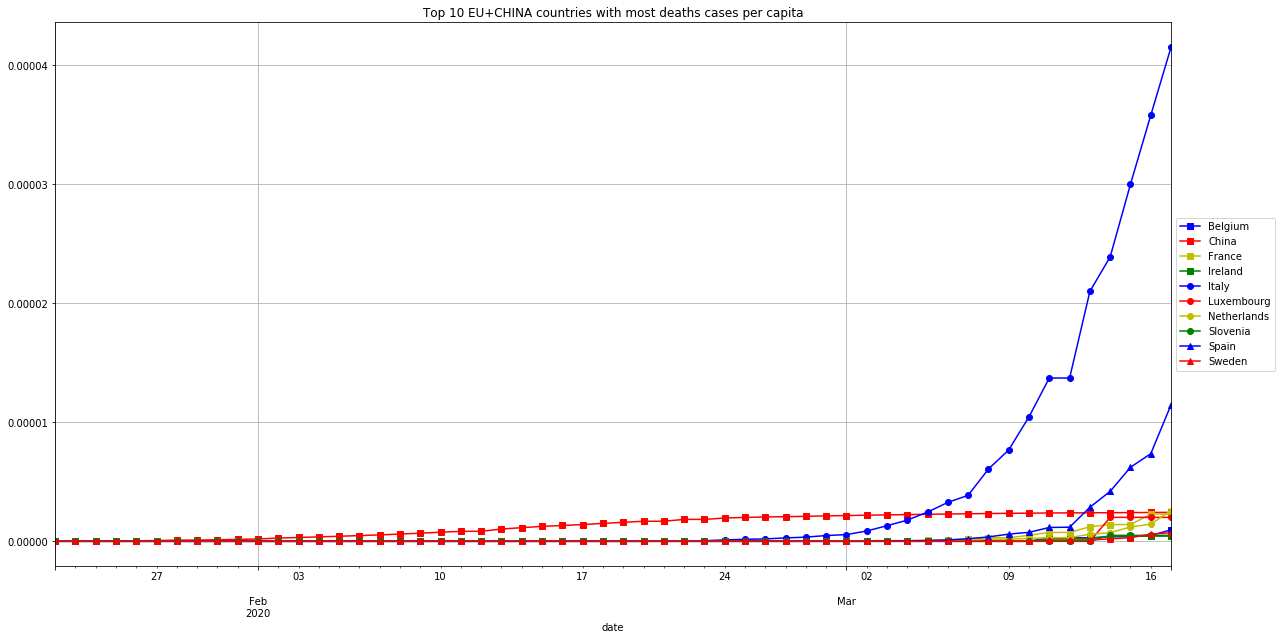

In [11]:
f, main_ax = plt.subplots()

f.set_figheight(10)
f.set_figwidth(20)

#Top 10 countries with confirmed cases per capita
top10 = death[death["country"].isin(eu_list+["China"])].groupby(["country"]).sum().sort_values("cases_per_capita",ascending=False).head(10).index.values

death_countries = death[death["country"].isin(top10)].groupby(["date","country"]).sum()

death_countries.unstack(level=1)["cases_per_capita"].plot(ax=main_ax,style=styles)
main_ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
main_ax.set_title("Top 10 EU+CHINA countries with most deaths cases per capita")
plt.grid()

In [ ]:
f, main_ax = plt.subplots()

f.set_figheight(10)
f.set_figwidth(20)

#Top 10 countries with confirmed cases per capita
top10 = recovered[recovered["country"].isin(eu_list + ["China"])].groupby(["country"]).sum().sort_values("cases_per_capita",ascending=False).head(10).index.values

recovered_countries = recovered[recovered["country"].isin(top10)].groupby(["date","country"]).sum()

recovered_countries.unstack(level=1)["cases_per_capita"].plot(ax=main_ax,style=styles)
main_ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
main_ax.set_title("Top 10 EU+CHINA countries with most recovered cases per capita")
plt.grid()